In [1]:
!pip install matplotlib
!pip install qutip
!pip install numpy 
!pip install scipy
!pip install Cython  

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_proj_ev as me

from IPython.display import display, Math, Latex

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-3.25940238  0.          0.          0.        ]
 [ 0.          0.11780972 -0.23561945  0.        ]
 [ 0.         -0.23561945  0.11780972  0.        ]
 [ 0.          0.          0.          3.02378293]]

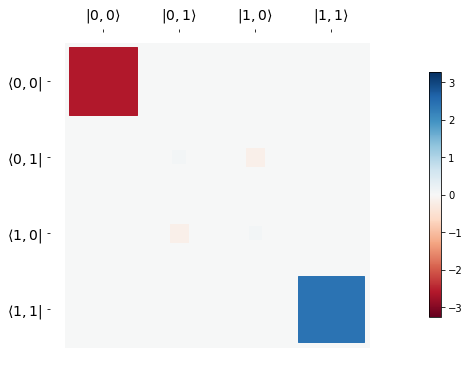

In [2]:
N = 2
Jx = .15
Jy = .25 
Jz = .1
h = 1.

me.Heisenberg_Hamiltonian("XXX", N, True, Jx, Jy, Jz, h)

In [3]:
me.classical_ops("XYZ", N, Jx, Jy, Jz, h)

(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[3. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 2. 0.]
  [0. 0. 0. 0.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.+0.j         0.+0.j         0.+0.j         0.+0.23561945j]
  [0.+0.j         0.+0.j         0.+0.31415927j 0.+0.j        ]
  [0.+0.j         0.-0.31415927j 0.+0.j         0.+0.j        ]
  [0.-0.23561945j 0.+0.j         0.+0.j         0.+0.j        ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.+0.j         0.+0.j         0.+0.j         0.+0.35342917j]
  [0.+0.j         0.+0.j         0.+0.4712389j  0.+0.j        ]
  [0.+0.j         0.-0.4712389j  0.+0.j         0.+0.j        ]
  [0.-0.35342917j 0.+0.j         0.+0.j         0.+0.j        ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.          0.        

In [4]:
len(me.one_body_spin_ops(N))

4

The result is not a density operator


AttributeError: 'NoneType' object has no attribute 'shape'

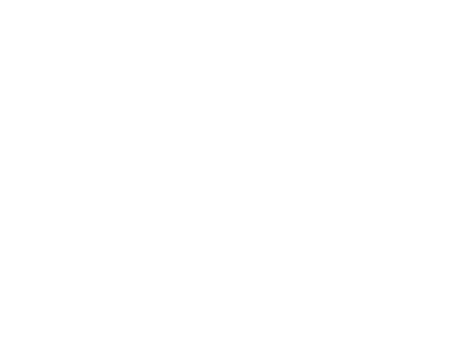

In [5]:
a = len(me.one_body_spin_ops(N))
b = len(me.one_body_spin_ops(N)[0])

coeffs_me1 = np.pi * 10**-6 * np.full((a,b),1.)

me.n_body_max_ent_state(1, N, coeffs_me1, True)